                                            **LSTM**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Forecast (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 - 7s - 295ms/step - loss: 0.1287 - val_loss: 0.0319 - learning_rate: 1.0000e-03
Epoch 2/50
25/25 - 1s - 34ms/step - loss: 0.0263 - val_loss: 0.0213 - learning_rate: 1.0000e-03
Epoch 3/50
25/25 - 1s - 50ms/step - loss: 0.0181 - val_loss: 0.0139 - learning_rate: 1.0000e-03
Epoch 4/50
25/25 - 1s - 30ms/step - loss: 0.0134 - val_loss: 0.0145 - learning_rate: 1.0000e-03
Epoch 5/50
25/25 - 1s - 51ms/step - loss: 0.0142 - val_loss: 0.0145 - learning_rate: 1.0000e-03
Epoch 6/50
25/25 - 2s - 68ms/step - loss: 0.0136 - val_loss: 0.0115 - learning_rate: 1.0000e-03
Epoch 7/50
25/25 - 1s - 36ms/step - loss: 0.0136 - val_loss: 0.0111 - learning_rate: 1.0000e-03
Epoch 8/50
25/25 - 2s - 62ms/step - loss: 0.0129 - val_loss: 0.0110 - learning_rate: 1.0000e-03
Epoch 9/50
25/25 - 1s - 50ms/step - loss: 0.0126 - val_loss: 0.0109 - learning_rate: 1.0000e-03
Epoch 10/50
25/25 - 1s - 40ms/step - loss: 0.0127 - val_loss: 0.0109 - learning_rate: 1.0000e-03
Epoch 11/50
25/25 - 1s - 46ms/step - l

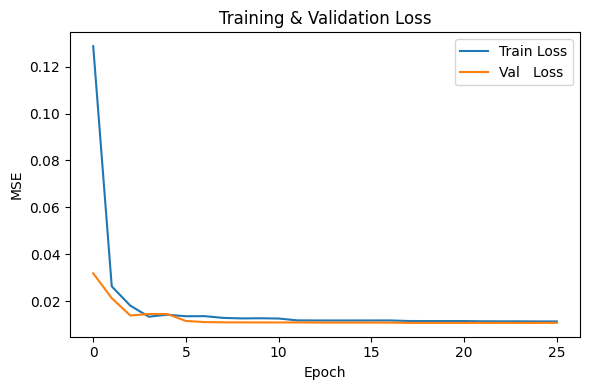

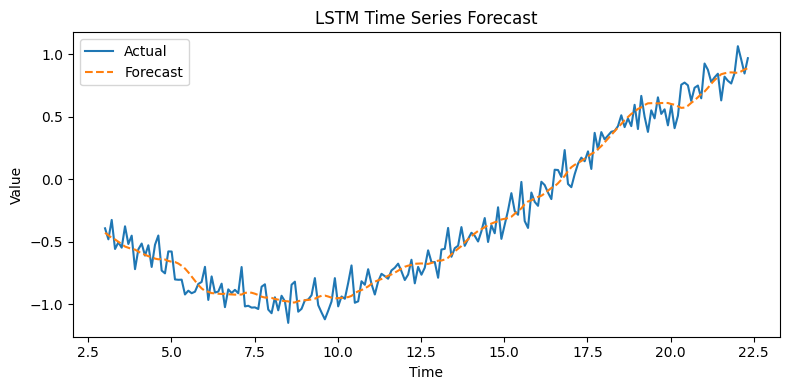

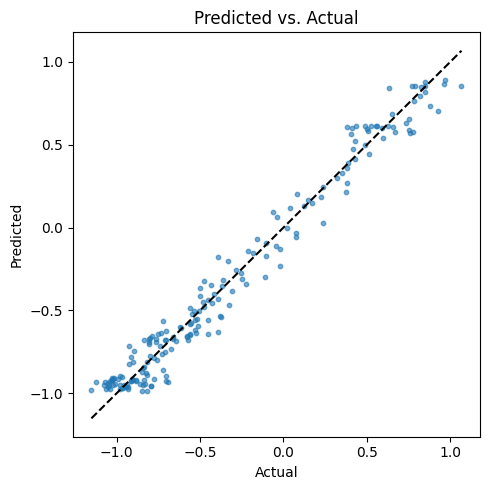

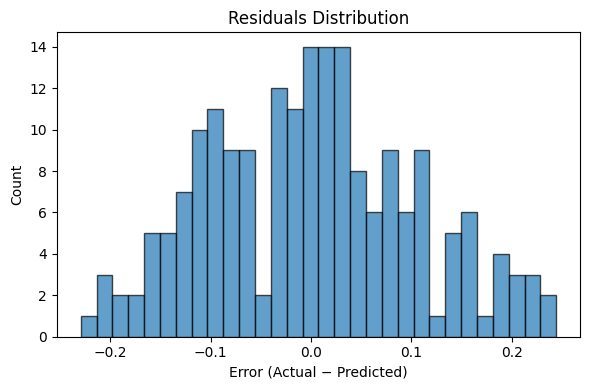

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ─── 1) Reproducibility ───────────────────────────────────────────
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# ─── 2) Generate synthetic time series ────────────────────────────
t = np.linspace(0, 100, 1000)
series = np.sin(0.2 * t) + 0.1 * np.random.randn(len(t))

# ─── 3) Prepare sequences ─────────────────────────────────────────
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

timesteps = 30
features  = 1
X, y = create_sequences(series, timesteps)
X = X.reshape(-1, timesteps, features)

# ─── 4) Train/Validation Split ────────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ─── 5) Build the LSTM Model ──────────────────────────────────────
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(timesteps, features)),
    LSTM(32, activation='tanh'),
    Dense(1, name='Forecast')
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# ─── 6) Callbacks ─────────────────────────────────────────────────
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# ─── 7) Train ──────────────────────────────────────────────────────
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=2
)

# ─── 8) Forecast & Metrics ─────────────────────────────────────────
y_pred = model.predict(X_val).flatten()
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"\nValidation MSE: {mse:.4f}   MAE: {mae:.4f}\n")

# ─── 9) Plotting ───────────────────────────────────────────────────
# a) Loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],    label='Train Loss')
plt.plot(history.history['val_loss'],label='Val   Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.tight_layout()
plt.show()

# b) Actual vs. Forecast
time_axis = t[timesteps : timesteps + len(y_val)]
plt.figure(figsize=(8,4))
plt.plot(time_axis, y_val,    label='Actual',    linewidth=1.5)
plt.plot(time_axis, y_pred,   label='Forecast',  linewidth=1.5, linestyle='--')
plt.title('LSTM Time Series Forecast')
plt.xlabel('Time'); plt.ylabel('Value')
plt.legend(); plt.tight_layout()
plt.show()

# c) Scatter plot: Predicted vs. Actual
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_pred, s=10, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.title('Predicted vs. Actual')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

# d) Residuals histogram
residuals = y_val - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Error (Actual − Predicted)'); plt.ylabel('Count')
plt.tight_layout()
plt.show()


                           **AutoEncoder**

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Enc-128 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dec-128 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,968 (820.19 KB)

 Trainable params: 209,968 (820.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
235/235 - 5s - 19ms/step - loss: 0.0601 - val_loss: 0.0334 - learning_rate: 1.0000e-03
Epoch 2/50
235/235 - 5s - 20ms/step - loss: 0.0273 - val_loss: 0.0222 - learning_rate: 1.0000e-03
Epoch 3/50
235/235 - 6s - 24ms/step - loss: 0.0203 - val_loss: 0.0181 - learning_rate: 1.0000e-03
Epoch 4/50
235/235 - 3s - 11ms/step - loss: 0.0173 - val_loss: 0.0158 - learning_rate: 1.0000e-03
Epoch 5/50
235/235 - 5s - 22ms/step - loss: 0.0154 - val_loss: 0.0143 - learning_rate: 1.0000e-03
Epoch 6/50
235/235 - 5s - 22ms/step - loss: 0.0141 - val_loss: 0.0134 - learning_rate: 1.0000e-03
Epoch 7/50
235/235 - 5s - 21ms/step - loss: 0.0134 - val_loss: 0.0128 - learning_rate: 1.0000e-03
Epoch 8/50
235/235 - 6s - 25ms/step - loss: 0.0129 - val_loss: 0.0124 - learning_rate: 1.0000e-03
Epoch 9/50
235/235 - 4s - 19ms/step - loss: 0.0125 - val_loss: 0.0120 - learning_rate: 1.0000e-03
Epoch 10/50
235/235 - 3s - 11ms/step - loss: 0.0122 - val_loss: 0.0117 - learning_rate: 1.0000e-03
Epoch 11/50
235/235

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Silhouette Score of KMeans on latent space: 0.109


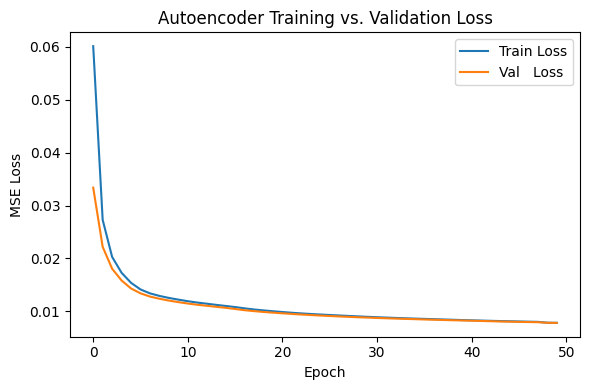

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


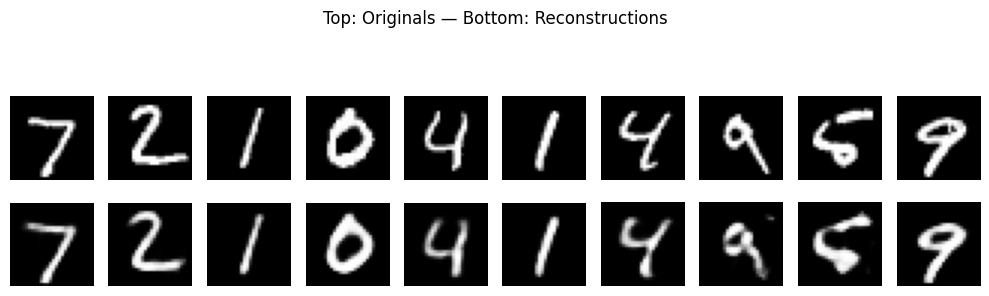

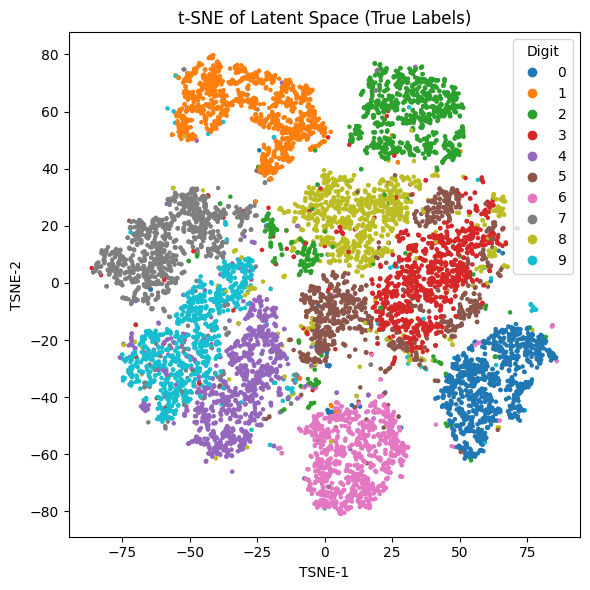

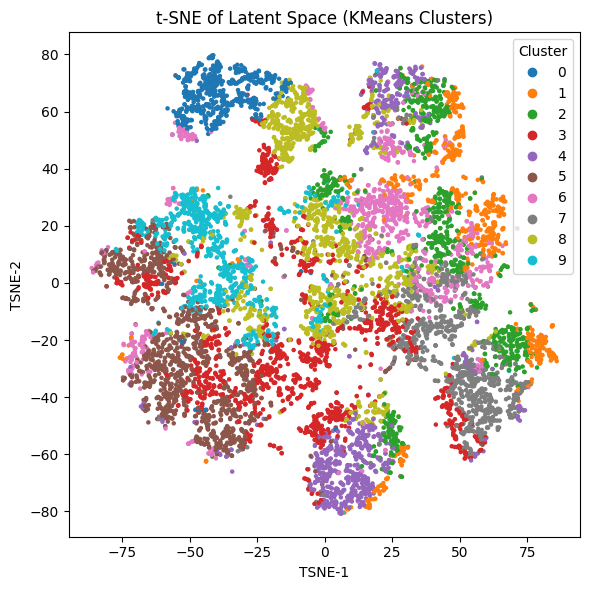

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# ─── 1) Reproducibility ───────────────────────────────────────────
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# ─── 2) Load & preprocess MNIST (with labels!) ───────────────────
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.
x_test  = x_test.reshape(-1, 28*28).astype('float32') / 255.

# ─── 3) Build Autoencoder ────────────────────────────────────────
input_dim, latent_dim = 28*28, 32
inputs = Input(shape=(input_dim,), name="Input")
h_enc  = Dense(128, activation='relu', name="Enc-128")(inputs)
z      = Dense(latent_dim, activation='relu', name="Latent")(h_enc)
h_dec  = Dense(128, activation='relu', name="Dec-128")(z)
outputs= Dense(input_dim, activation='sigmoid', name="Output")(h_dec)

autoencoder = Model(inputs, outputs, name="Autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# ─── 4) Callbacks & Training ─────────────────────────────────────
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    validation_data=(x_test, x_test),
    callbacks=callbacks,
    verbose=2
)

# ─── 5) Extract Encoder & Latent Codes ───────────────────────────
encoder = Model(inputs, z, name="Encoder")
latent_train = encoder.predict(x_train)
latent_test  = encoder.predict(x_test)

# ─── 6) Clustering & Metrics ─────────────────────────────────────
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_ids = kmeans.fit_predict(latent_test)
sil_score = silhouette_score(latent_test, cluster_ids)
print(f"Silhouette Score of KMeans on latent space: {sil_score:.3f}")

# ─── 7) t-SNE Projection ─────────────────────────────────────────
z2d = TSNE(n_components=2, init='pca', random_state=42).fit_transform(latent_test)

# ─── 8) PLOTS ─────────────────────────────────────────────────────
# a) Loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],    label='Train Loss')
plt.plot(history.history['val_loss'],label='Val   Loss')
plt.title('Autoencoder Training vs. Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.tight_layout(); plt.show()

# b) Original vs. Reconstructed (first 10 samples)
decoded = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(10,3))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray'); plt.axis('off')
    # reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded[i].reshape(28,28), cmap='gray'); plt.axis('off')
plt.suptitle('Top: Originals — Bottom: Reconstructions', y=1.05)
plt.tight_layout(); plt.show()

# c) t-SNE colored by true digit labels
plt.figure(figsize=(6,6))
scatter = plt.scatter(z2d[:,0], z2d[:,1], c=y_test, s=5, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Digit", loc='upper right')
plt.title('t-SNE of Latent Space (True Labels)')
plt.xlabel('TSNE-1'); plt.ylabel('TSNE-2'); plt.tight_layout(); plt.show()

# d) t-SNE colored by KMeans clusters
plt.figure(figsize=(6,6))
scatter = plt.scatter(z2d[:,0], z2d[:,1], c=cluster_ids, s=5, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Cluster", loc='upper right')
plt.title('t-SNE of Latent Space (KMeans Clusters)')
plt.xlabel('TSNE-1'); plt.ylabel('TSNE-2'); plt.tight_layout(); plt.show()
